# Segmented Housing Price Predictions
## Goals:
   - Price Testing houses as accurately as possible
   - segment newly predicted prices into 4 seperate housing thresholds/segments
   - Explain Process & Findings

## Link to Original Datasets & Prompt:
https://www.kaggle.com/datasets/gauravduttakiit/the-great-real-estate-data-challenge

In [1]:
# These are all the modules we will be using to optimize and view our XGBoosted Models
import pandas as pd # For DataFrame Manipulation
import numpy as np # For mathematical operations in Python
from sklearn.preprocessing import OneHotEncoder #Dummies for Categorical Variables
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer #For XGBoost to optimze boosting paramters based off AUC Score
from sklearn.model_selection import GridSearchCV# To optimize XGBoost HyperParameters
from sklearn.model_selection import train_test_split #To split our data in fitting models
from sklearn.decomposition import PCA # Finding Top components in prediction
from sklearn import preprocessing # scaling the data for PCA 
import matplotlib.pyplot as plt # PCA scree plot visualization
from sklearn.metrics import average_precision_score, precision_recall_curve
import xgboost as xgb #Finally our XGBoost module to be trained with our dataset

In [2]:
#Initial View Of Our Dataset
train_df = pd.read_csv('train.csv')
train_df.head()

,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate
0,2009,2009-01-02,Greenwich,40 ETTL LN UT 24,711270.0,975000.0,Condo,Condominium,2,760,1.025953
1,2009,2009-01-02,East Hampton,18 BAUER RD,119970.0,189900.0,Single Family,Detached House,3,921,1.025953
2,2009,2009-01-02,Ridgefield,48 HIGH VALLEY RD.,494530.0,825000.0,Single Family,Detached House,3,982,1.025953
3,2009,2009-01-02,Old Lyme,56 MERIDEN RD,197600.0,450000.0,Single Family,Detached House,3,976,1.025953
4,2009,2009-01-02,Naugatuck,13 CELENTANO DR,105440.0,200000.0,Single Family,Detached House,3,947,1.025953


In [3]:
#prelimanry data cleaning, confirming data is categorized correctly 
train_df.dtypes

Year                   int64
Date                  object
Locality              object
Address               object
Estimated Value      float64
Sale Price           float64
Property              object
Residential           object
num_rooms              int64
carpet_area            int64
property_tax_rate    float64
dtype: object

# PCA Compression:
######  - Principal Component Analysis aids in finding the variables that contribute to the most of our data variability in terms of the loading score. By reducing the dimensions of our dataset, we can get a better look at what makes our future machines tick

In [4]:
# Our PCA visualiation will need an identifable index if we would 
# like to annotate in the future. The address column looks like a great option
adresses = train_df['Address']

In [5]:
#PCA compression does not work well wtith categorical variabales, so let's create a new dataframe
pca_df = train_df.drop(['Sale Price', "Date", 'Address'], axis=1)
pca_df = pd.get_dummies(pca_df, columns = ['Locality','Property', 'Residential'])

In [6]:
# We have 553,952 samples now... so that's fun
#the dummies gave us 186 columns to work from 
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553952 entries, 0 to 553951
Columns: 186 entries, Year to Residential_Triplex
dtypes: float64(2), int64(3), uint8(181)
memory usage: 116.8 MB


In [7]:
#Next we need to standardize our remaining continuous variables to all carry an even weigt in PCA's dimension reduction
pca_scaled_df = preprocessing.scale(pca_df)

In [8]:
# We are ready to Instantiate & fit our PCA model!
pca = PCA()
pca.fit(pca_scaled_df)
pca_data = pca.transform(pca_scaled_df)

In [9]:
#Scree plots are a great way to visualize PC influence, let's start by formatting the data for vizzing
per_var = np.round(pca.explained_variance_ratio_ *100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

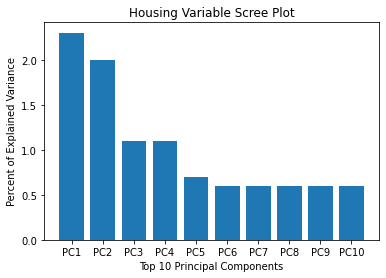

<Figure size 432x288 with 0 Axes>

In [10]:
# Now let's build the scree plot to see how each Principal Component did
plt.bar(x=range(1, 11), height=per_var[:10], tick_label=labels[:10])
plt.ylabel("Percent of Explained Variance")
plt.xlabel("Top 10 Principal Components")
plt.title("Housing Variable Scree Plot")
plt.show()
plt.clf()

In [11]:
#Let's build a visualization of how our PCA model grouped the sample points
pca_viz = pd.DataFrame(pca_data, index= train_df['Address'].values, columns=labels)
pca_viz.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,PC186
40 ETTL LN UT 24,-3.536869,-1.725331,-0.555830,0.198180,-0.869194,4.280020,1.239080,0.633832,-0.067736,0.255210,...,0.304207,0.234745,-0.004080,-0.029131,-0.008211,-0.008599,3.269297e-16,3.791476e-15,3.258351e-15,-1.133421e-15
18 BAUER RD,0.479423,1.225562,-0.025819,-0.031584,-1.320184,-0.385341,2.053480,-0.176390,0.612663,-0.004033,...,1.008865,-0.274051,-0.016963,0.055242,0.006159,0.007765,-3.003739e-15,2.820031e-15,-7.106958e-16,-1.140360e-15
48 HIGH VALLEY RD.,0.557295,1.205034,-0.116579,-0.021165,-0.471944,0.896944,0.746122,0.207691,-0.561225,-0.080377,...,0.392680,-0.064669,0.016981,0.019666,0.000310,0.001443,-2.864961e-15,1.348985e-15,-1.848674e-15,-2.306094e-15
56 MERIDEN RD,0.682292,1.308280,-0.069310,-0.032911,-1.057458,-0.003136,0.782980,0.481668,-0.343299,-0.107563,...,0.372904,-0.088428,0.009150,0.020530,0.001997,0.002535,-3.447829e-15,8.216295e-16,-1.626630e-15,-1.917516e-15
13 CELENTANO DR,0.536715,1.038341,0.059883,-0.030405,-0.764352,-0.467326,0.842256,0.534447,-0.222957,-0.104426,...,0.531064,-0.188882,-0.007028,0.034086,0.003766,0.008921,-1.199627e-15,1.571030e-15,-9.882516e-16,-1.084849e-15


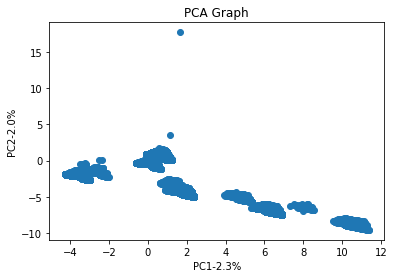

<Figure size 432x288 with 0 Axes>

In [12]:
plt.scatter(pca_viz.PC1, pca_viz.PC2)
plt.title("PCA Graph")
plt.xlabel('PC1-{0}%'.format(per_var[0]))
plt.ylabel('PC2-{0}%'.format(per_var[1]))
plt.show()
plt.clf()

In [13]:
#Lastly, we can see the influence each variable has in variance change by ordering our loading scores lowest to high
loading_scores = pd.Series(pca.components_[0], index= pca_df.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
print(f'Variable importance ranked 1-10:', sorted_loading_scores[:10])

Variable importance ranked 1-10: num_rooms                     0.444885
carpet_area                   0.428199
Residential_Condominium       0.409572
Property_Condo                0.405183
Residential_Detached House    0.224717
Residential_Triplex           0.220700
Property_Three Family         0.218968
Property_Single Family        0.218532
Residential_Fourplex          0.151676
Property_Four Family          0.150538
dtype: float64


## Yay! We finished our PCA compression!
##### Obviously, the size of the home will factor in most of the varaiability (Seen Via the loading scores of carpet_area & num_rooms)
##### What's more interesting is the type of homes that factor in the most varaiability 
- Condos
- Detatched House
- Triplex
##### You're going to see these types of residence accounting for high profits in the real world, so our data seems to be refelecting pretty well

# XGBoosting
##### - Extreme Gradient Boosting creates decision trees into a Random Forest with greedy algorithims to weigh it's variables when deciding how to classify/predict inputs. The PCA Compression above visualizes how the model should handle it's voting system when handling data prediction

##### - After Correctly modifying our data, we can begin to fit our XGB model and measure it's predictions

In [14]:
#Split our training data up so that we can begin fitting our model
X = train_df.drop(['Sale Price', 'Address', "Date"], axis=1).copy()
y = train_df['Sale Price'].copy()

In [15]:
# Convert object variables to categorical type so that it can fit in DMatrix
X["Locality"]=X['Locality'].astype('category')
X["Property"]=X['Property'].astype('category')
X["Residential"]=X['Residential'].astype('category')

In [16]:
#Ensure our data types were changed
X.dtypes

Year                    int64
Locality             category
Estimated Value       float64
Property             category
Residential          category
num_rooms               int64
carpet_area             int64
property_tax_rate     float64
dtype: object

In [17]:
#initiate our Dmatrix
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

In [18]:
#train our XGBoost as a linear regression model to estimate house prices(continuous)
params = {'objective': 'reg:squarederror', 'eval_metric' : 'aucpr' }
lnr_xgb = xgb.train(params, dtrain)

In [19]:
#with the same Dmatrix, we can predict the outcomes for our training set
y_pred = lnr_xgb.predict(dtrain)
y_pred

array([974451.56, 202426.11, 777268.  , ..., 302950.25, 302950.25,
       509045.94], dtype=float32)

In [20]:
#We have to change our outputs to binary to assess the accuracy & precision recall Scores
#A threshold classfies outputs as 1 & 0 for confusion matrix to predict 
threshold = np.median(y_pred)
# Bins classify outputs as correct or incorrect
y_bin = np.where(y_pred >= threshold, 1, 0)


In [21]:
# Calculate average precision score
average_precision = average_precision_score(y_bin, y_pred)

# Get precision-recall curve
precision, recall, _ = precision_recall_curve(y_bin, y_pred)



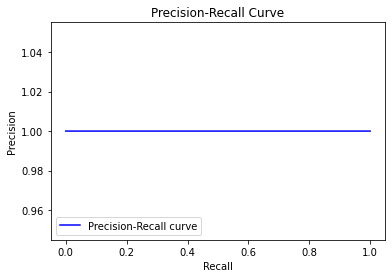

Average Precision Score: 1.0


In [22]:
# We can plot the Precision-Recall Curve to see the accuracy of and speed
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Print average precision score
print(f"Average Precision Score: {average_precision}")



# Note:
###### - The data we used today was very clean in it's original condition, and thus fit our XGboost model very well. In most cases we would like to use GridSearchCV() to find the optmal hyperpapramter to prevent overfitting (Bias/Variance Trade off)
###### - When comparing predictions to the orignal Sale Prices, the XGBoost model did extremely well, usually only a few hundred dollars off it actual price. We can take this model to pretty confidently predict our test datset since it paramteres are relatively simple. 

In [23]:
#Back to our original testset, let's test the gains for each sold house
train_df['Gain'] = train_df["Sale Price"] - train_df["Estimated Value"]
train_df['Gain']
#I want to looks at size and quantiles of our sales to segemtn
gain_range = train_df["Gain"].max() - train_df["Gain"].min()
gain_quantiles = train_df["Gain"].quantile([0, 0.25, 0.5, 0.75])
gain_quantiles

0.00   -876830000.0
0.25        23240.0
0.50        69280.0
0.75       125000.0
Name: Gain, dtype: float64

In [24]:
#There's a wide range in our gains, but the quantiles split remearkable evenly
quantile = [0, 0.25, 0.5, 0.75, 1]
train_df['quantile_range'] = pd.qcut(train_df['Gain'], quantile, labels=False) + 1
train_df['quantile_range'].value_counts()

3    138512
2    138491
1    138490
4    138459
Name: quantile_range, dtype: int64

# Predicting a new dataset:
###### -Our Model is finished, so we can begin predicting our second dataset and segment them according to gain(like the code above)
###### - For any new data coming in , we need to ensure it's formatted according the original model

In [25]:
# We have our fitted model, so let's bring in the test set to create som new predictions
test_df = pd.read_csv('test.csv')

In [26]:
test_df.head()

,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate,Segment
0,2023,2023-01-01,Old Lyme,12 SWAN AVE,151400.0,0,Residential,Detached House,3,947.0,1.46,0
1,2023,2023-01-01,Ridgefield,59 LINCOLN LANE,686900.0,0,Residential,Detached House,3,1051.0,1.46,0
2,2023,2023-01-04,Cromwell,6 GROVE RD,152030.0,0,Residential,Detached House,3,925.0,1.46,0
3,2023,2023-01-04,New Haven,346 CONCORD ST,156130.0,0,Residential,Duplex,4,1210.0,1.46,0
4,2023,2023-01-04,Beacon Falls,14 LASKY ROAD,108970.0,0,Residential,Detached House,3,1089.0,1.46,0


In [27]:
#Once again, we have to format the data so we can process it into the Dmatrix for predictions
xgb_test_df = test_df.drop(['Address', "Date","Segment"], axis=1).copy()

In [28]:
X2 = xgb_test_df.drop(['Sale Price'],axis=1).copy()

In [29]:
X2["Locality"]=X['Locality'].astype('category')
X2["Property"]=X['Property'].astype('category')
X2["Residential"]=X['Residential'].astype('category')

In [30]:
X2.dtypes

Year                    int64
Locality             category
Estimated Value       float64
Property             category
Residential          category
num_rooms               int64
carpet_area           float64
property_tax_rate     float64
dtype: object

In [31]:
#Once again, we manipuate our DF into a DMatrix
dtest = xgb.DMatrix(X2, enable_categorical=True)

In [32]:
#And Bam, here's our new predictions via XGBoost Model
predictions = lnr_xgb.predict(dtest)

In [33]:
#We've got to add our predictions back into the testing DataFrame
test_df["Sale Price"] = predictions.astype('int64')

In [34]:
#Make sure that worked
test_df.head()

,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate,Segment
0,2023,2023-01-01,Old Lyme,12 SWAN AVE,151400.0,232259,Residential,Detached House,3,947.0,1.46,0
1,2023,2023-01-01,Ridgefield,59 LINCOLN LANE,686900.0,977284,Residential,Detached House,3,1051.0,1.46,0
2,2023,2023-01-04,Cromwell,6 GROVE RD,152030.0,232259,Residential,Detached House,3,925.0,1.46,0
3,2023,2023-01-04,New Haven,346 CONCORD ST,156130.0,229690,Residential,Duplex,4,1210.0,1.46,0
4,2023,2023-01-04,Beacon Falls,14 LASKY ROAD,108970.0,111049,Residential,Detached House,3,1089.0,1.46,0


In [35]:
#We have our new Sale Prices, we can now calculate the potential gain
test_df['Gain'] = test_df["Sale Price"] - test_df["Estimated Value"]
test_df['Gain'].head()

0     80859.0
1    290384.0
2     80229.0
3     73560.0
4      2079.0
Name: Gain, dtype: float64

In [36]:
#Let's take look and compare the gain range of the test and train
gain_range = test_df["Gain"].max() - test_df["Gain"].min()
gain_quantiles = test_df["Gain"].quantile([0, 0.25, 0.5, 0.75])
gain_quantiles

0.00   -60780238.00
0.25       60916.75
0.50       95096.00
0.75      142676.75
Name: Gain, dtype: float64

In [37]:
#Our quantiles are placed once again
test_df['Segment'] = pd.qcut(test_df['Gain'], quantile, labels=False) + 1
test_df['Segment'].value_counts()

2    10989
4    10989
1    10989
3    10987
Name: Segment, dtype: int64

In [38]:
#ensuring data types 
test_df['Segment'].dtype

dtype('int64')

In [39]:
#The Prompt asked for specifc segment names, so we need to change our mapping
mapping = {1: 'Budget Properties', 2: 'Standard Properties', 3: 'Valuable Properties', 4: 'Premium Properties'}

# Convert the column from Numbers to Categories
test_df['Segment'] = test_df['Segment'].replace(mapping)
test_df.head()

,Year,Date,Locality,Address,Estimated Value,Sale Price,Property,Residential,num_rooms,carpet_area,property_tax_rate,Segment,Gain
0,2023,2023-01-01,Old Lyme,12 SWAN AVE,151400.0,232259,Residential,Detached House,3,947.0,1.46,Standard Properties,80859.0
1,2023,2023-01-01,Ridgefield,59 LINCOLN LANE,686900.0,977284,Residential,Detached House,3,1051.0,1.46,Premium Properties,290384.0
2,2023,2023-01-04,Cromwell,6 GROVE RD,152030.0,232259,Residential,Detached House,3,925.0,1.46,Standard Properties,80229.0
3,2023,2023-01-04,New Haven,346 CONCORD ST,156130.0,229690,Residential,Duplex,4,1210.0,1.46,Standard Properties,73560.0
4,2023,2023-01-04,Beacon Falls,14 LASKY ROAD,108970.0,111049,Residential,Detached House,3,1089.0,1.46,Budget Properties,2079.0


In [40]:
#Our newly predicted data is ready to go! Let's save it as a csv
test_df.to_csv('predicted house prices.csv')

# Conclusions
###### -XGBoosting is a machine learning model that comes pretty well optimized right out the box, which makes it a great go to when quickly optimizing data
###### -The data we ran throught after fitting was quite consistent to the predictions with our training set which means we could pretty confidently relay the twchniques onto knew data as long as we have the same data pre-modified when inputting our model

###### - Our original datasets provided a relatively clean experience when predicting the house prices. In larger, more complex datasets hyperparameter searches would be crtiical to our model's tuning process to prevent overfitting our training data. 

###  for deeper insights, thikning processes, and visualization please refer to this Noetbook's accompanying Tableau Dashboard & Paper Summary

In [41]:
loading = pd.DataFrame(sorted_loading_scores)

In [43]:
loading.to_csv("loading scores.csv")

In [46]:
city_df = test_df[(test_df['Locality'] == 'Stamford') | (test_df['Locality'] == 'Waterbury') | (test_df['Locality'] == 'Norwalk') | (test_df['Locality'] == 'Hartford') | (test_df['Locality'] == 'Danbury') | (test_df['Locality'] == 'Darien') | (test_df['Locality'] == 'West Hartford') | (test_df['Locality'] == 'Ridgefield') | (test_df['Locality'] == 'New Haven') | (test_df['Locality'] == 'Bristol')]

In [61]:
grouped = city_df.groupby('Locality')
def select_top_10(df):
    return df.nlargest(10, 'Gain')

# Apply the function to each group and concatenate the results
top_10_df = grouped.apply(select_top_10).reset_index(drop=True)

# Display the top 10 rows for each category
top_10_df.to_csv("city_address.csv")